This is an extension of [this](https://www.kaggle.com/kageyama/fork-of-fastai-blindness-detection-resnet34) notebook, which extends upon [this](https://www.kaggle.com/kageyama/fastai-blindness-detection-resnet34) notebook.

In this experiment, I try ordinal variables using [this](https://arxiv.org/abs/0704.1028) technique. Basically, I transform the targets to look like multilabel classification, then apply this method for making predictions:

> "...our methods scans output nodes in the order O1, O2,....,OK. It stop when the output of a node is smaller than the predefined threshold T (e.g. 0.5) or no nodes left. The index k of the last node Ok whose output is bigger than T is the predicted category of the data point."

So basically, I'll apply sigmoid to the model's outputs, then threshold at 0.5 and find the position one before the first zero.

In [1]:
%matplotlib inline  
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd

from fastai import *
from fastai.vision import *
# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from sklearn.utils import shuffle

print(os.listdir("../input"))

['resized-2015-2019-blindness-detection-images', 'pretrained-pytorch-models', 'densenet201', 'aptos2019-blindness-detection', 'fastai-pretrained-models', 'resnet34']


In [2]:
Path('/tmp/.cache/torch/checkpoints/').mkdir(exist_ok=True, parents=True)
!cp /kaggle/input/fastai-pretrained-models/* /tmp/.cache/torch/checkpoints/
!ls /tmp/.cache/torch/checkpoints/

densenet121-a639ec97.pth  resnet50-19c8e357.pth
densenet169-b2777c0a.pth  squeezenet1_0-a815701f.pth
densenet201-c1103571.pth  squeezenet1_1-f364aa15.pth
resnet101-5d3b4d8f.pth	  vgg16_bn-6c64b313.pth


In [3]:
df_train_19 = pd.read_csv('../input/resized-2015-2019-blindness-detection-images/labels/trainLabels19.csv')
df_train_15 = pd.read_csv('../input/resized-2015-2019-blindness-detection-images/labels/trainLabels15.csv')
df_test_15 = pd.read_csv('../input/resized-2015-2019-blindness-detection-images/labels/testLabels15.csv')

x_train_19 = df_train_19['id_code']
y_train_19 = df_train_19['diagnosis']

In [4]:
import torch
import torch.utils.data
import torchvision

In [5]:
def get_label(diagnosis):
    return ','.join([str(i) for i in range(diagnosis + 1)])

In [6]:
df_train_19['label'] = df_train_19.diagnosis.apply(get_label)
df_train_15['label'] = df_train_15.level.apply(get_label)
df_test_15['label'] = df_test_15.level.apply(get_label)

In [7]:
df_train_15=df_train_15.rename(columns={"Image": "Id_code", "level": "diagnosis"})
df_test_15=df_test_15.rename(columns={"Image": "Id_code", "level": "diagnosis"})

In [8]:
import glob
import cv2
import numpy as np

def crop_image_from_gray(img,tol=7):
    """
    Crop out black borders
    https://www.kaggle.com/ratthachat/aptos-updated-preprocessing-ben-s-cropping
    """  
    
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        mask = gray_img>tol        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0):
            return img
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img


def circle_crop(img):   
    """
    Create circular crop around image centre    
    """    
    
    img = cv2.imread(img)
    img = crop_image_from_gray(img)    
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    return img 

In [9]:
class APTOSImageList(ImageList):
    def open(self, fn:PathOrStr) -> Image:
        img = circle_crop(str(fn))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img / 255.0
        return Image(px=pil2tensor(img, np.float32))

In [10]:
tfms=get_transforms(do_flip=True,
                      flip_vert=True, 
                      max_rotate=360., 
                      max_zoom=1.0,
                      max_warp=None, 
                      max_lighting=0.2,
                      p_affine=0.,
                      p_lighting=0.
                     )

In [11]:
path = Path("/kaggle/input/resized-2015-2019-blindness-detection-images")
src = (
    APTOSImageList.from_folder(path, presort=True, recurse=True)
    .filter_by_func(lambda item: item.parts[-2] != "resized test 19")
    .filter_by_func(lambda item: item.parts[-2] != "resized test 15")
        #.filter_by_func(lambda item: item.parts[-2] != "resized train 15")
        #.split_by_valid_func(lambda item: item.parts[-2] == "resized train 19")
    .split_by_rand_pct(0.1, 42)
    #.split_subsets(0.01, 0.01, 42)
    )

In [12]:
train_label_15_dict = dict(zip(list(df_train_15.image), list(df_train_15.label)))
train_label_19_dict = dict(zip(list(df_train_19.id_code), list(df_train_19.label)))
test_label_15_dict = dict(zip(list(df_test_15.image), list(df_test_15.label)))

def label_func(item):
    if item.parts[-2] == "resized train 15":
        return train_label_15_dict[item.stem]
    elif item.parts[-2] == "resized test 15":
        return test_label_15_dict[item.stem]
    elif item.parts[-2] == "resized train 19":
        return train_label_19_dict[item.stem]
    else:
        assert(False)

src = src.label_from_func(label_func)

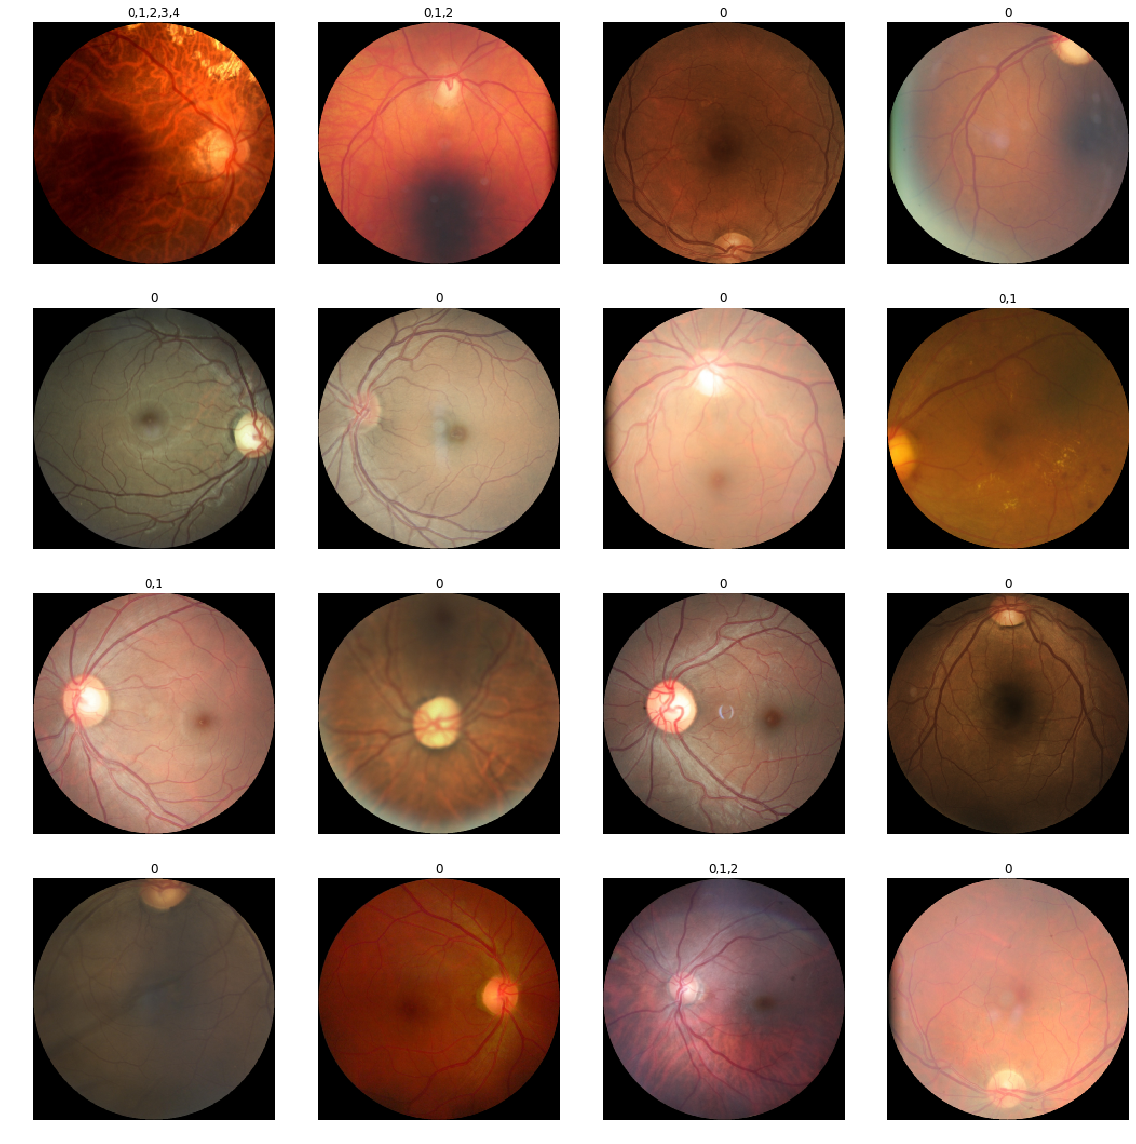

In [13]:
data = (
    src.transform(tfms,size=224)
    .databunch(bs=16)
    .normalize()
)
data.show_batch()

In [14]:
# check classes
print(f'Classes: \n {data.classes}')

Classes: 
 ['0', '0,1', '0,1,2', '0,1,2,3', '0,1,2,3,4']


In [15]:
def get_preds(arr):
    mask = arr == 0
    return np.clip(np.where(mask.any(1), mask.argmax(1), 5) - 1, 0, 4)

In [16]:
last_output = torch.tensor([
    [1.7226, 1.7226, 1.7226, 1.7226, 1.7226],
    [0, 0, 0, 0, 1.7226],
    [0.12841, -7.6266, -6.3899, -2.1333, -0.48995],
    [0.68119, 1.7226, -1.9895, -0.097746, 0.53576]
])
arr = (torch.sigmoid(last_output) > 0.5).numpy(); arr

array([[1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0],
       [1, 1, 0, 0, 1]], dtype=uint8)

In [17]:
# Test output
assert (get_preds(arr) == np.array([4, 0, 0, 1])).all()

In [18]:
class ConfusionMatrix(Callback):
    "Computes the confusion matrix."

    def on_train_begin(self, **kwargs):
        self.n_classes = 0

    def on_epoch_begin(self, **kwargs):
        self.cm = None

    def on_batch_end(self, last_output:Tensor, last_target:Tensor, **kwargs):
        preds = torch.tensor(get_preds((torch.sigmoid(last_output) > 0.5).cpu().numpy()))
        
        targs = torch.tensor(get_preds(last_target.cpu().numpy()))

        if self.n_classes == 0:
            self.n_classes = last_output.shape[-1]
            self.x = torch.arange(0, self.n_classes)
        
        cm = ((preds==self.x[:, None]) & (targs==self.x[:, None, None])).sum(dim=2, dtype=torch.float32)
        if self.cm is None: self.cm =  cm
        else:               self.cm += cm

    def on_epoch_end(self, **kwargs):
        self.metric = self.cm
        

@dataclass
class KappaScore(ConfusionMatrix):
    "Compute the rate of agreement (Cohens Kappa)."
    weights:Optional[str]=None      # None, `linear`, or `quadratic`

    def on_epoch_end(self, last_metrics, **kwargs):
        sum0 = self.cm.sum(dim=0)
        sum1 = self.cm.sum(dim=1)
        expected = torch.einsum('i,j->ij', (sum0, sum1)) / sum0.sum()
        if self.weights is None:
            w = torch.ones((self.n_classes, self.n_classes))
            w[self.x, self.x] = 0
        elif self.weights == "linear" or self.weights == "quadratic":
            w = torch.zeros((self.n_classes, self.n_classes))
            w += torch.arange(self.n_classes, dtype=torch.float)
            w = torch.abs(w - torch.t(w)) if self.weights == "linear" else (w - torch.t(w)) ** 2
        else: raise ValueError('Unknown weights. Expected None, "linear", or "quadratic".')
        k = torch.sum(w * self.cm) / torch.sum(w * expected)
        return add_metrics(last_metrics, 1-k)

In [19]:
kappa = KappaScore(weights="quadratic")
learn = create_cnn(data, models.densenet201, model_dir="/tmp/model/")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


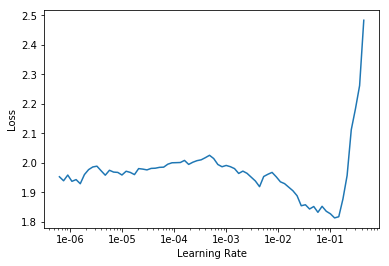

In [20]:
learn.lr_find()
learn.recorder.plot()

In [21]:
# first time learning
learn.fit_one_cycle(6, 1.1e-2)

epoch,train_loss,valid_loss,time
0,0.816695,0.783557,40:12


In [22]:
# save stage
learn.save('stage-1')

In [23]:
sample_df = pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')
sample_df.head()

,id_code,diagnosis
0,0005cfc8afb6,0
1,003f0afdcd15,0
2,006efc72b638,0
3,00836aaacf06,0
4,009245722fa4,0


In [24]:
learn.data.add_test(ImageList.from_df(sample_df,'../input/aptos2019-blindness-detection',folder='test_images',suffix='.png'))

In [25]:
preds, y = learn.get_preds(DatasetType.Test)

In [26]:
sample_df.diagnosis = get_preds((preds > 0.5).cpu().numpy())
sample_df.head(10)

,id_code,diagnosis
0,0005cfc8afb6,0
1,003f0afdcd15,0
2,006efc72b638,0
3,00836aaacf06,0
4,009245722fa4,0
5,009c019a7309,0
6,010d915e229a,0
7,0111b949947e,0
8,01499815e469,0
9,0167076e7089,0


In [27]:
sample_df.to_csv('submission.csv',index=False)